<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting ELISA data from organoids

<strong>Input Data:</strong>

`ABCA7_spheroid_Abeta ELISA_011125_4Week.csv` 

`ABCA7_spheroid_Abeta ELISA_122124.csv`


<strong>Figures:</strong>

`fig4`
`ED13`

<strong>Last Run All:</strong>
June 18, 2025


In [2]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import numpy as np

from ABCA7lof2.utils import apply_custom_plot_style
from ABCA7lof2.boxplotting import plot_boxplot_by_treatment, detect_outliers_iqr
apply_custom_plot_style()

Load data

In [3]:
# load data
data = pd.read_csv('../../elisa_data/ABCA7_spheroid_Abeta ELISA_011125_4Week.csv', index_col=0)
data_subset = data[(data['Line'] != 'G2') & (data['Line'] != 'Y+500uM')]
data_subset.columns = ['line', 'x', 'y', 'Abeta42', 'Abeta40', 'Abeta42/40']
data_subset.index = np.arange(len(data_subset))

Remove outliers

In [4]:
# Remove outliers (significant also when not doing so, but makes it very difficult to plot otherwise)
outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta40'].values)
data_40 = data_subset[np.invert(outliers)]

outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta42'].values)
data_42 = data_subset[np.invert(outliers)]


In [5]:
data_40['line'].value_counts()

line
E3       20
y622     19
Y+1mM    14
Name: count, dtype: int64

In [6]:
data_42['line'].value_counts()

line
E3       20
y622     19
Y+1mM    14
Name: count, dtype: int64

Do stats for Ab40

In [7]:
from scipy.stats import shapiro, levene, ttest_ind

group1 = data_40[data_40['line'] == 'E3']['Abeta40']
group2 = data_40[data_40['line'] == 'y622']['Abeta40']
group3 = data_40[data_40['line'] == 'Y+1mM']['Abeta40']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
print('comparison 1 E3, y622, Y+1mM')
print(p_norm1, p_norm2, p_norm3)

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print('p_levene E3 vs y622', p_levene)

stat, p_levene = levene(group2, group3)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print('p_levene y622 vs Y+1mM', p_levene)



comparison 1 E3, y622, Y+1mM
0.8190778968694478 0.38262778610886194 0.9991934991054935
p_levene E3 vs y622 0.03802120111132281
p_levene y622 vs Y+1mM 0.4138898180733708


In [8]:
# Ab40 pvalues
group1 = data_40[data_40['line'] == 'E3']['Abeta40']
group2 = data_40[data_40['line'] == 'y622']['Abeta40']
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=False)

group1 = data_40[data_40['line'] == 'y622']['Abeta40']
group2 = data_40[data_40['line'] == 'Y+1mM']['Abeta40']
t_stat, p_value_B= ttest_ind(group1, group2, equal_var=True)

formatted_pvalues_40 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B]]


stats for Ab42

In [9]:

group1 = data_42[data_42['line'] == 'E3']['Abeta42']
group2 = data_42[data_42['line'] == 'y622']['Abeta42']
group3 = data_42[data_42['line'] == 'Y+1mM']['Abeta42']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
print('comparison 1 E3, y622, Y+1mM')
print(p_norm1, p_norm2, p_norm3)

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print('p_levene E3 vs y622', p_levene)

stat, p_levene = levene(group2, group3)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print('p_levene y622 vs Y+1mM', p_levene)

comparison 1 E3, y622, Y+1mM
0.6575234494009531 0.32736185124127476 0.7670599472088769
p_levene E3 vs y622 0.2025311121489404
p_levene y622 vs Y+1mM 0.8239648454817042


In [10]:
# Ab42 pvalues
group1 = data_42[data_42['line'] == 'E3']['Abeta42']
group2 = data_42[data_42['line'] == 'y622']['Abeta42']
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=True)

group1 = data_42[data_42['line'] == 'y622']['Abeta42']
group2 = data_42[data_42['line'] == 'Y+1mM']['Abeta42']
t_stat, p_value_B= ttest_ind(group1, group2, equal_var=True)

formatted_pvalues_42 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B]]


plot the data

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_97676/2279058483.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


E3 vs. y622: p=7.537e-04
y622 vs. Y+1mM: p=0.044
E3 vs. y622: p=1.851e-04


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_97676/2279058483.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


y622 vs. Y+1mM: p=0.002


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


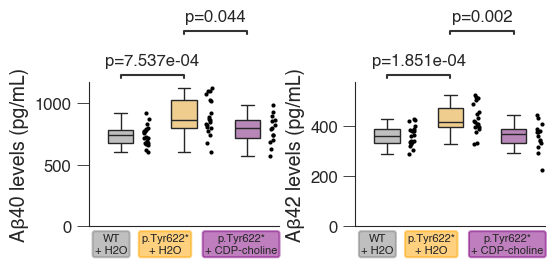

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 2))

plt.sca(ax1)

ax1 = plot_boxplot_by_treatment(data_40, 'line', 'Abeta40', order = ['E3', 'y622', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_40['Abeta40']+50), pvalues=formatted_pvalues_40)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Aβ40 levels (pg/mL)')

ax1.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax1.text(0.7, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax1.text(1.9, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)

plt.sca(ax2)

ax2 = plot_boxplot_by_treatment(data_42, 'line', 'Abeta42', order = ['E3', 'y622', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_42['Abeta42']+50), pvalues=formatted_pvalues_42)
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Aβ42 levels (pg/mL)')

ax2.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax2.text(0.7, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax2.text(1.9, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)

plt.subplots_adjust(left=0.07, right=0.9, top=0.8, bottom=0.08, wspace=0.4)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig4/abeta_elisa.pdf', dpi=300, bbox_inches='tight')

### Plot earlier time points & lower drug concentrations

In [12]:
# load data
data = pd.read_csv('../../elisa_data/ABCA7_spheroid_Abeta ELISA_122124.csv', index_col=None)
data_subset = data[(data['Unnamed: 0'] != 'G2')]
data_subset.columns = ['line', 'x', 'y', 'z', 'Abeta42', 'Abeta40', 'Abeta42/40']
data_subset.index = np.arange(len(data_subset))

outlier removal

In [13]:
# Remove outliers (significant also when not doing so, but makes it very difficult to plot otherwise)
outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta40'].values)
data_40 = data_subset[np.invert(outliers)]

outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta42'].values)
data_42 = data_subset[np.invert(outliers)]


Stats ab40

In [14]:

group1 = data_40[data_40['line'] == 'E3']['Abeta40']
group2 = data_40[data_40['line'] == 'y622']['Abeta40']
group3 = data_40[data_40['line'] == 'Y+500uM']['Abeta40']
group4 = data_40[data_40['line'] == 'Y+1mM']['Abeta40']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
stat4, p_norm4 = shapiro(group4)

print('comparison 1')
print(p_norm1, p_norm2, p_norm3, p_norm4)

stat, p_levene1 = levene(group1, group2)
stat, p_levene2 = levene(group2, group3)
stat, p_levene3 = levene(group2, group4)
print('p_levene E3 vs y622', p_levene1)
print('p_levene y622 vs Y+500uM', p_levene2)
print('p_levene y622 vs Y+1mM', p_levene3)


comparison 1
0.9761577500432812 0.7858873439005157 0.12188525274628983 0.209388808469558
p_levene E3 vs y622 0.02771267797624425
p_levene y622 vs Y+500uM 0.04265863644131657
p_levene y622 vs Y+1mM 0.14388305189092862


In [15]:
# Ab40
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=False)
t_stat, p_value_B= ttest_ind(group2, group3, equal_var=False)
t_stat, p_value_C= ttest_ind(group2, group4, equal_var=True)

formatted_pvalues_40 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B, p_value_C]]
formatted_pvalues_40

['p=2.709e-04', 'p=0.715', 'p=0.049']

stats ab42

In [16]:

group1 = data_42[data_42['line'] == 'E3']['Abeta42']
group2 = data_42[data_42['line'] == 'y622']['Abeta42']
group3 = data_42[data_42['line'] == 'Y+500uM']['Abeta42']
group4 = data_42[data_42['line'] == 'Y+1mM']['Abeta42']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
stat4, p_norm4 = shapiro(group4)

print('comparison 1')
print(p_norm1, p_norm2, p_norm3, p_norm4)

stat, p_levene1 = levene(group1, group2)
stat, p_levene2 = levene(group2, group3)
stat, p_levene3 = levene(group2, group4)
print('p_levene E3 vs y622', p_levene1)
print('p_levene y622 vs Y+500uM', p_levene2)
print('p_levene y622 vs Y+1mM', p_levene3)


comparison 1
0.09746710925499026 0.7435813493640189 0.934528943807727 0.5306010724109042
p_levene E3 vs y622 0.5234011306249455
p_levene y622 vs Y+500uM 0.058169012391182225
p_levene y622 vs Y+1mM 0.6898530396945679


In [17]:
# Ab42
t_stat, p_value_A = ttest_ind(group1, group2, equal_var=True)
t_stat, p_value_B= ttest_ind(group2, group3, equal_var=True)
t_stat, p_value_C= ttest_ind(group2, group4, equal_var=True)

formatted_pvalues_42 = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_value_A, p_value_B, p_value_C]]
formatted_pvalues_42

['p=0.041', 'p=0.480', 'p=0.413']

plot the data

E3 vs. y622: p=2.709e-04


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_97676/2279058483.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_97676/2279058483.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


y622 vs. Y+500uM: p=0.715
y622 vs. Y+1mM: p=0.049
E3 vs. y622: p=0.041
y622 vs. Y+500uM: p=0.480
y622 vs. Y+1mM: p=0.413


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


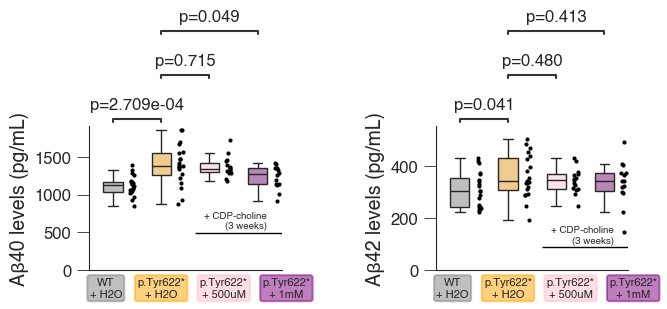

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2))

plt.sca(ax1)

ax1 = plot_boxplot_by_treatment(data_40, 'line', 'Abeta40', order = ['E3', 'y622', 'Y+500uM', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+500uM'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+500uM': 'pink', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_40['Abeta40']+50), pvalues=formatted_pvalues_40)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Aβ40 levels (pg/mL)')

ax1.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax1.text(1, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax1.text(3.6, -0.05, "p.Tyr622*\n+ 1mM", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)
ax1.text(2.3, -0.05, "p.Tyr622*\n+ 500uM", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="pink", ec="pink", alpha=0.5), fontsize=8)

plt.sca(ax2)

ax2 = plot_boxplot_by_treatment(data_42, 'line', 'Abeta42', order = ['E3', 'y622', 'Y+500uM', 'Y+1mM'], pairs = [('E3', 'y622'), ('y622', 'Y+500uM'), ('y622', 'Y+1mM')],palette={'E3': 'grey', 'y622': 'orange', 'Y+500uM': 'pink', 'Y+1mM': 'purple'}, 
                                ylim = np.max(data_42['Abeta42']+50), pvalues=formatted_pvalues_42)
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Aβ42 levels (pg/mL)')

ax2.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax2.text(1, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax2.text(3.6, -0.05, "p.Tyr622*\n+ 1mM", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)
ax2.text(2.3, -0.05, "p.Tyr622*\n+ 500uM", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="pink", ec="pink", alpha=0.5), fontsize=8)


ax1.hlines(y=490, xmin=1.7, xmax=8, linestyles='solid', color='black', linewidth=1)
ax1.text(3.2, 550, '+ CDP-choline\n(3 weeks)', ha='right', fontsize=7)

# Add horizontal line and CDP-choline text for the second plot
ax2.hlines(y=90, xmin=1.7, xmax=4, linestyles='solid', color='black', linewidth=1)
ax2.text(3.2, 105, '+ CDP-choline\n(3 weeks)', ha='right', fontsize=7)

plt.subplots_adjust(left=0.07, right=0.9, top=0.8, bottom=0.08, wspace=0.8)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed13/abeta_elisa_3weeks.pdf', dpi=300, bbox_inches='tight')